### Preprocessing

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [194]:
df = pd.read_csv('facial-keypoints-detection/training.csv')

In [195]:
y_full = df.drop(columns=['Image']).values.astype(np.float32)
x_full = [[int(n) for n in img_str.split()] for img_str in df['Image']]
x_full = np.array(x_full, dtype=np.float32).reshape((-1, 1, 96, 96)) / 255

In [196]:
def plot(img, keypoint_sets):
    plt.imshow(img, cmap='grey')
    for y in keypoint_sets:
        key_points = y.reshape((-1, 2))
        plt.scatter(key_points[:, 0], key_points[:, 1])
    plt.axis('off')
    plt.show()

In [197]:
def multi_plot(imgs, keypoint_sets, cols=4):
    n = len(imgs)
    rows = (n + cols - 1) // cols
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs[i], cmap='grey')
        plt.axis('off')
        for y in keypoint_sets:
            key_points = y[i].reshape((-1, 2))
            plt.scatter(key_points[:, 0], key_points[:, 1], s=4)
    plt.tight_layout()
    plt.show()

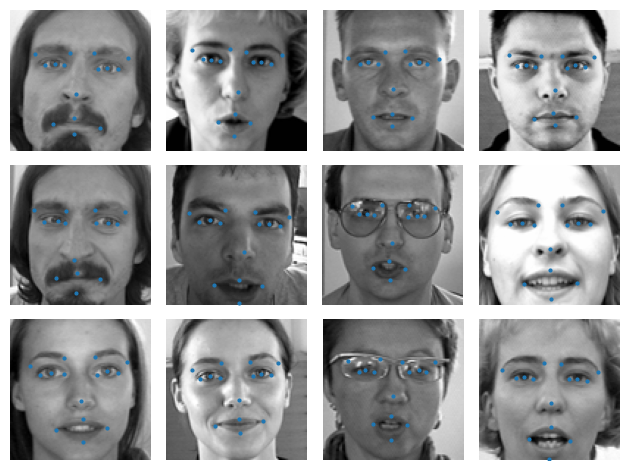

In [198]:
multi_plot(x_full[:12, 0], [y_full[:12]])

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_full, 
    y_full,
    test_size=0.125,
    shuffle=True,
    random_state=0,
)

imputer = KNNImputer()
y_train_full = imputer.fit_transform(y_train_full)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, 
    y_train_full,
    test_size=0.15,
    shuffle=True,
    random_state=0,
)

print(f'{len(x_train)} train, {len(x_valid)} valid, {len(x_test)} test')

5241 train, 926 valid, 882 test


# Default Model

In [200]:
import torch
from torch import nn, optim
import torch.nn.functional as F

DEVICE = 'mps'

In [201]:
def np2torch(x, device=DEVICE):
    return torch.from_numpy(x).to(device)


def torch2np(x):
    return x.detach().cpu().numpy()

In [202]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 30)


    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.reshape((-1, 9216))
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [203]:
def batch_iterate(x, y, batch_size, device=DEVICE):
    permutation = np.random.permutation(y.shape[0])
    for s in range(0, y.shape[0], batch_size):
        idxs = permutation[s:s + batch_size]
        yield np2torch(x[idxs], device), np2torch(y[idxs], device)

In [204]:
def evaluate(model, x, y, device=DEVICE):
    model.eval()
    loss_sum = 0
    r2_sum = 0
    n_batches = 0
    for x, y in batch_iterate(x, y, batch_size=100, device=device):
        y_pred = model(x)
        loss = F.mse_loss(y_pred, y).item()
        var = torch.mean(torch.square(y - torch.mean(y, dim=0))).item()
        r2 = 1 - loss / var
        loss_sum += loss
        r2_sum += r2
        n_batches += 1
    print(f'loss: {loss_sum / n_batches:.3f}, R^2: {r2_sum / n_batches:.3f}')

In [218]:
model = CNN().to(DEVICE)
model.load_state_dict(torch.load('checkpoints/model0.pth'))
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.99)

In [219]:
# model.train()

# for epoch in range(100):
#     if (epoch + 1) % 10 == 0:
#         print('epoch:', epoch + 1)

#     for x, y in batch_iterate(x_train, y_train, batch_size=100):
#         opt.zero_grad()
#         loss = F.mse_loss(model(x), y)
#         loss.backward()
#         opt.step()

#     scheduler.step()
    
# torch.save(model.state_dict(), 'checkpoints/model0.pth')

In [220]:
evaluate(model, x_valid, y_valid)

loss: 4.804, R^2: 0.557


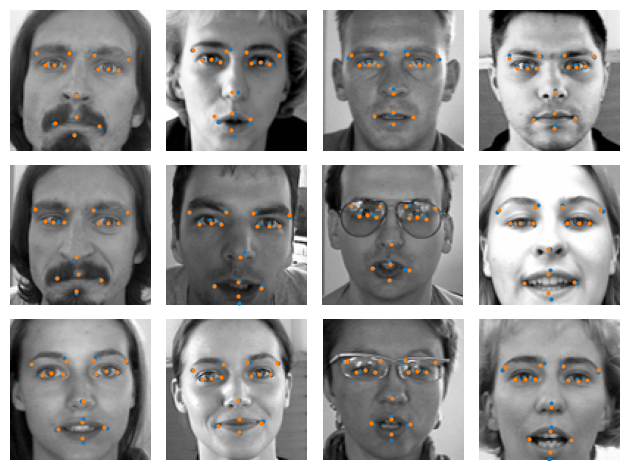

In [221]:
y_pred = torch2np(model(np2torch(x_full[:12])).clip(0, 95))
multi_plot(x_full[:12, 0], [y_full[:12], y_pred[:12]])

# Attacking the Model

In [222]:
def fgsm(model, x, y, eps):
    delta = torch.zeros_like(x, requires_grad=True)
    loss = F.mse_loss(model(x + delta), y)
    loss.backward()
    return eps * torch.sign(delta.grad)

In [223]:
def pgd(model, x, y, eps, alpha=0.1, n_iters=100):
    delta = torch.zeros_like(x, requires_grad=True)
    for _ in range(n_iters):
        loss = F.mse_loss(model(x + delta), y)
        loss.backward()
        with torch.no_grad():
            delta += alpha * delta.grad
            delta.clip_(-eps, eps)
            delta.grad.zero_()
    return delta.detach()

In [224]:
def evaluate_fgsm(model, x, y, eps, device=DEVICE):
    model.eval()
    loss_sum = 0
    r2_sum = 0
    n_batches = 0
    for x, y in batch_iterate(x, y, batch_size=100, device=device):
        x += fgsm(model, x, y, eps)
        y_pred = model(x)
        loss = F.mse_loss(y_pred, y).item()
        var = torch.mean(torch.square(y - torch.mean(y, dim=0))).item()
        r2 = 1 - loss / var
        loss_sum += loss
        r2_sum += r2
        n_batches += 1
    print(f'loss: {loss_sum / n_batches:.3f}, R^2: {r2_sum / n_batches:.3f}')

In [225]:
def evaluate_pgd(model, x, y, eps, device=DEVICE):
    model.eval()
    loss_sum = 0
    r2_sum = 0
    n_batches = 0
    for x, y in batch_iterate(x, y, batch_size=100, device=device):
        x += pgd(model, x, y, eps)
        y_pred = model(x)
        loss = F.mse_loss(y_pred, y).item()
        var = torch.mean(torch.square(y - torch.mean(y, dim=0))).item()
        r2 = 1 - loss / var
        loss_sum += loss
        r2_sum += r2
        n_batches += 1
    print(f'loss: {loss_sum / n_batches:.3f}, R^2: {r2_sum / n_batches:.3f}')

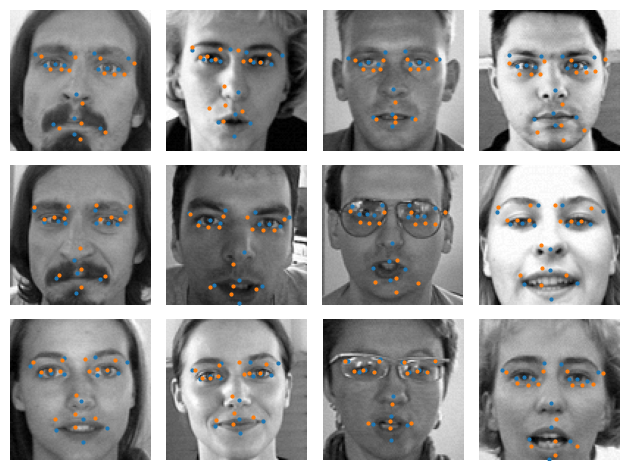

In [226]:
delta = fgsm(model, np2torch(x_full[:12]), np2torch(y_full[:12]), 0.01)
y_pred = torch2np(model(np2torch(x_full[:12]) + delta).clip(0, 95))
multi_plot(x_full[:12, 0] + torch2np(delta)[:12, 0], [y_full[:12], y_pred[:12]])

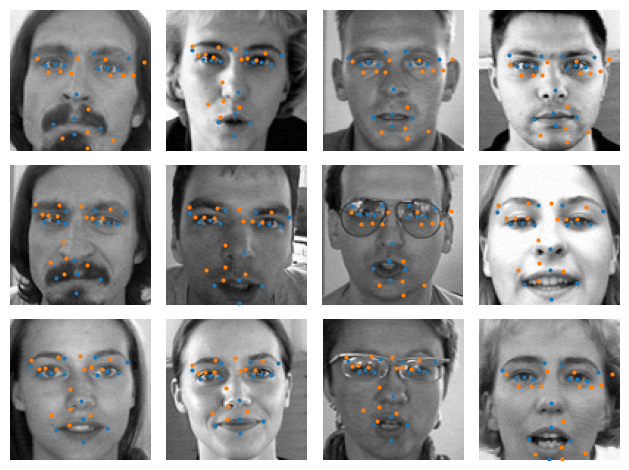

In [227]:
delta = pgd(model, np2torch(x_full[:12]), np2torch(y_full[:12]), 0.01)
y_pred = torch2np(model(np2torch(x_full[:12]) + delta).clip(0, 95))
multi_plot(x_full[:12, 0] + torch2np(delta)[:12, 0], [y_full[:12], y_pred[:12]])

In [228]:
print('no attack:')
evaluate(model, x_valid, y_valid)
print('fgsm attack:')
evaluate_fgsm(model, x_valid, y_valid, 0.01)
print('pgd attack:')
evaluate_pgd(model, x_valid, y_valid, 0.01)

no attack:
loss: 4.741, R^2: 0.569
fgsm attack:
loss: 29.151, R^2: -1.903
pgd attack:
loss: 85.446, R^2: -7.552


# Robust Model

In [234]:
robust_model = CNN().to(DEVICE)
# robust_model.load_state_dict(torch.load('checkpoints/robust_model0.pth'))
opt = optim.Adam(robust_model.parameters(), lr=0.001, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.99)

In [235]:
robust_model.train()

delta = torch.zeros((100, 1, 96, 96), requires_grad=True, device=DEVICE)
eps = 0.005
batch_size = 100

for epoch in range(100):
    if (epoch + 1) % 10 == 0:
        print('epoch:', epoch + 1)
        
    for x, y in batch_iterate(x_train, y_train, batch_size=batch_size):
        if len(x) != batch_size:
            continue

        opt.zero_grad()
        loss = F.mse_loss(robust_model(x + delta), y)
        loss.backward()
        opt.step()

        with torch.no_grad():
            x += eps * delta.grad.sign_()
            delta.grad.zero_()

        opt.zero_grad()
        loss = F.mse_loss(robust_model(x), y)
        loss.backward()
        opt.step()
    
    eps += 0.0001
    scheduler.step()
    
torch.save(model.state_dict(), 'checkpoints/robust_model0.pth')

epoch: 10
epoch: 20
epoch: 30
epoch: 40
epoch: 50
epoch: 60
epoch: 70
epoch: 80
epoch: 90
epoch: 100


In [237]:
print('no attack:')
evaluate(robust_model, x_valid, y_valid)
print('fgsm attack:')
evaluate_fgsm(robust_model, x_valid, y_valid, 0.01)
print('pgd attack:')
evaluate_pgd(robust_model, x_valid, y_valid, 0.01)

no attack:
loss: 5.288, R^2: 0.508
fgsm attack:
loss: 6.860, R^2: 0.346
pgd attack:
loss: 6.330, R^2: 0.422


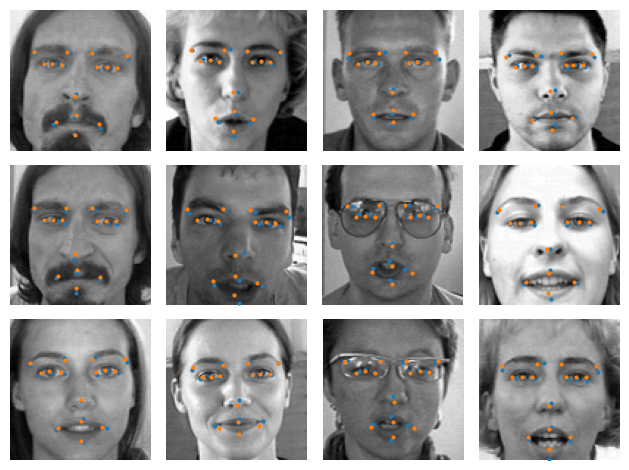

In [238]:
delta = fgsm(robust_model, np2torch(x_full[:12]), np2torch(y_full[:12]), 0.01)
y_pred = torch2np(robust_model(np2torch(x_full[:12]) + delta).clip(0, 95))
multi_plot(x_full[:12, 0] + torch2np(delta)[:12, 0], [y_full[:12], y_pred[:12]])

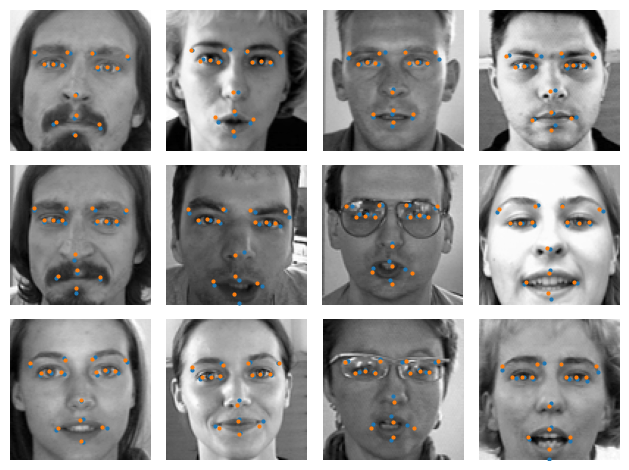

In [239]:
delta = pgd(robust_model, np2torch(x_full[:12]), np2torch(y_full[:12]), 0.01)
y_pred = torch2np(robust_model(np2torch(x_full[:12]) + delta).clip(0, 95))
multi_plot(x_full[:12, 0] + torch2np(delta)[:12, 0], [y_full[:12], y_pred[:12]])